<a href="https://colab.research.google.com/github/Efekannnn/AgirDepresyonTespit/blob/main/xlm_roberta_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install matplotlib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
try:
    df = pd.read_csv('cleaned_combined_data.csv')
except FileNotFoundError:
    print("Error: 'your_dataset.csv' not found. Please upload your dataset file.")
    df = pd.DataFrame({'cleaned_text': [], 'label': []}) # Create an empty DataFrame to avoid errors later

if not {'cleaned_text', 'label'}.issubset(df.columns):
    print("Error: Your dataset must have 'text' and 'label' columns.")

# drive bağlantı
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# boşluk temizle
df['cleaned_text'] = df['cleaned_text'].str.strip()

# datayı test ve eğitmek üzere ayır
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)
#!huggingface-cli login

# model ve tokenizer tanımlama
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# datayı tokenize etme
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = MentalHealthDataset(train_encodings, train_labels)
val_dataset = MentalHealthDataset(val_encodings, val_labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    report_to="none"
)
def save_times(training_time, inference_time, file_path):
       with open(file_path, 'w') as f:
           f.write(f"Training time: {training_time} seconds\n")
           f.write(f"Inference time: {inference_time} seconds\n")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    dogruluk = accuracy_score(labels, predictions)
    kesinlik = precision_score(labels, predictions)
    geri = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()

    ozgulluk = tn / (tn + fp)
    hassaslik = tp / (tp + fn)

    auc_score = roc_auc_score(labels, predictions)


    return {
        "accuracy": dogruluk,
        "precision": kesinlik,
        "recall": geri,
        "f1": f1,
        "specificity": ozgulluk,
        "sensitivity": hassaslik,
        "auc": auc_score
    }



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)
import time
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Specificity,Sensitivity,Auc
1,0.337100,0.629140,0.767745,0.705202,0.980357,0.820321,0.517350,0.980357,0.748854
2,0.333500,0.365859,0.874457,0.883929,0.883929,0.883929,0.863302,0.883929,0.873615
3,0.215000,0.296571,0.880734,0.866499,0.921429,0.893120,0.832808,0.921429,0.877118


Training time: 1100.0829808712006 seconds


In [ ]:
eval_metrics = trainer.evaluate()


with open("/content/drive/MyDrive/my_mental_health_model2/roberta/metrics_roberta.txt", "w") as f:
    for metric_name, metric_value in eval_metrics.items():
        f.write(f"{metric_name}: {metric_value}\n")

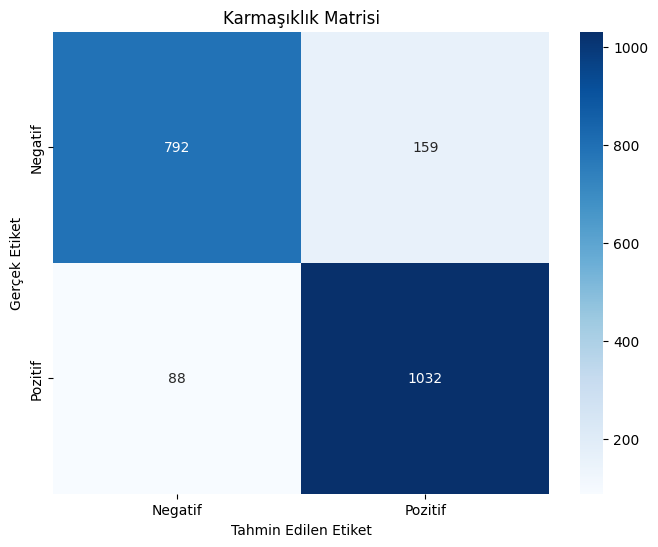

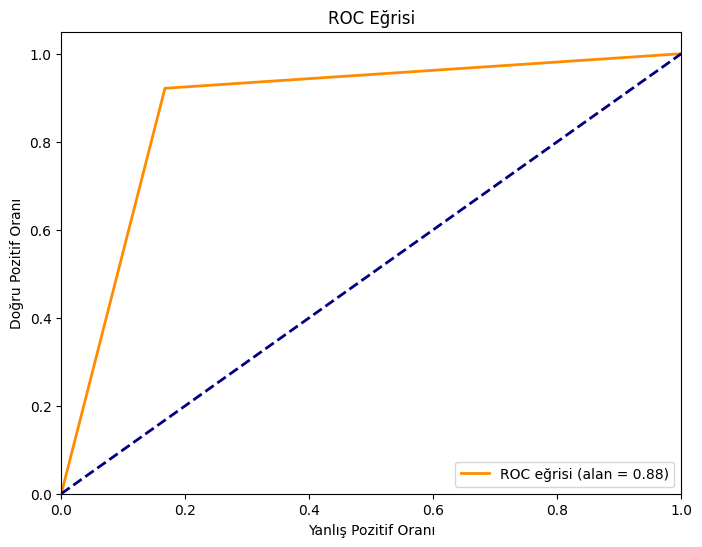

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negatif", "Pozitif"],
            yticklabels=["Negatif", "Pozitif"])
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Karmaşıklık Matrisi")
plt.show()


fpr, tpr, thresholds = roc_curve(val_labels, predicted_labels)
roc_auc = roc_auc_score(val_labels, predicted_labels)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC eğrisi (alan = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Yanlış Pozitif Oranı")
plt.ylabel("Doğru Pozitif Oranı")
plt.title("ROC Eğrisi")
plt.legend(loc="lower right")
plt.show()

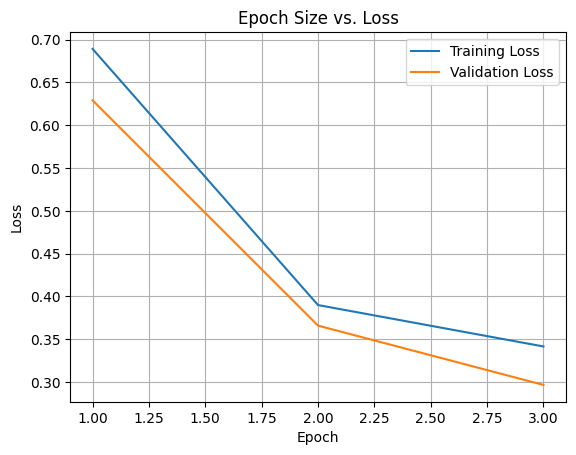

Inference time for a single prediction: 28.534430503845215 seconds
Accuracy: 0.8807339449541285


In [ ]:
import matplotlib.pyplot as plt


train_loss_values = trainer.state.log_history[::len(trainer.state.log_history) // training_args.num_train_epochs]
train_loss_values = [d['loss'] for d in train_loss_values if 'loss' in d]

eval_loss_values = [d['eval_loss'] for d in trainer.state.log_history if 'eval_loss' in d]


eval_loss_values = eval_loss_values[:training_args.num_train_epochs]

epochs = range(1, training_args.num_train_epochs + 1)

plt.plot(epochs, train_loss_values, label='Training Loss')

plt.plot(epochs, eval_loss_values, label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch Size vs. Loss")
plt.grid(True)
plt.legend()

plt.savefig("/content/drive/MyDrive/my_mental_health_model2/roberta/epoch_vs_loss.png")

plt.show()

model.save_pretrained("/content/drive/MyDrive/my_mental_health_model2/roberta")
tokenizer.save_pretrained("/content/drive/MyDrive/my_mental_health_model2/roberta")

start_time_i = time.time()
predictions = trainer.predict(val_dataset)
end_time_i = time.time()
inference_time = end_time_i - start_time_i
print(f"Inference time for a single prediction: {inference_time} seconds")

file_path = '/content/drive/MyDrive/my_mental_health_model2/roberta/training_inference_times.txt'
save_times(training_time, inference_time, file_path)

predicted_labels = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(val_labels, predicted_labels)
print(f"Accuracy: {accuracy}")